In [47]:
import pandas as pd
import geopandas as gpd
import uuid
import matplotlib.pyplot as plt
import re
from math import ceil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from shapely import wkt
import os
import ast

---
# <b>1. Create synthesized PFT table<b>

In [2]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
pft_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_standard_pft_fcover.csv'
    df = pd.read_csv(path, index_col=0)
    pft_dfs.append(df)
pft_fcover = pd.concat(pft_dfs)
    
# rename columns for ESS-Dive
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

# adjust column names and index
pft_fcover.columns = [camel_to_snake(col) for col in pft_fcover.columns]
pft_fcover.index.name = 'unit_id'

# export
pft_fcover = pft_fcover.replace({None: np.nan, '':np.nan})
pft_fcover.to_csv('synthesized_pft_fcover.csv', index=True, encoding='utf-8-sig')

In [3]:
pft_fcover.head(3)

,deciduous_shrub_cover,deciduous_tree_cover,evergreen_shrub_cover,evergreen_tree_cover,forb_cover,graminoid_cover,nonvascular_sum_cover,bryophyte_cover,lichen_cover,litter_cover,other_cover,water_cover,bareground_cover
unit_id,,,,,,,,,,,,,
120712b1,32.45,0.0,20.52,0.0,2.64,19.20,33.09,31.77,1.32,18.54,0.0,0.0,0.00
120713a1,0.00,0.0,0.00,0.0,1.96,28.75,37.25,36.60,0.65,77.78,0.0,0.0,11.11
120713b1,11.34,0.0,38.01,0.0,0.00,14.66,26.00,17.34,8.66,32.67,0.0,0.0,0.00


---
# 2. Create synthesized plot information (aux) table

## 2.a. Concatenate individual plot info tables

In [4]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
aux_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_plot_info.csv'
    df = pd.read_csv(path, index_col=0)
    aux_dfs.append(df)
aux = pd.concat(aux_dfs)

# set data types
intcols = ['surveyYear', 'surveyMonth', 'surveyDay', 'bioclimSubzone']
for col in intcols:
    aux[col] = aux[col].astype('Int64')

# adjust column names and index
aux.columns = [camel_to_snake(col) for col in aux.columns]
aux.index.name = 'unit_id'
    
aux.to_csv('etc/survey_unit_information_temp.csv', encoding='utf-8-sig')

## 2.b. Fill in missing plot information variables manually
Save as `survey_unit_information.csv` in main directory
- Manual assessment because some rows missing admin_unit, admin_country, bioclim_subzone

## 2.c. Summarize final plot information table

#### Columns

In [5]:
# ensure encoding is correct
aux = pd.read_csv('survey_unit_information.csv')
aux.to_csv('survey_unit_information.csv', encoding='utf-8-sig', index=False)
aux = pd.read_csv('survey_unit_information.csv')

In [6]:
aux.columns

Index(['unit_id', 'survey_year', 'survey_month', 'survey_day', 'plot_radius',
       'latitude_y', 'longitude_x', 'georef_source', 'georef_accuracy',
       'coord_epsg', 'data_subsource', 'data_source', 'data_source_html',
       'data_subsource_citation', 'survey_method', 'fcover_scale',
       'survey_purpose', 'geometry', 'admin_unit', 'admin_country',
       'fire_years', 'bioclim_subzone', 'duplicated_coords',
       'duplicated_date'],
      dtype='object')

#### Plot counts per data subsource

In [7]:
aux.groupby('data_subsource').count()['unit_id']

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    185
Atqasuk Villarreal (pub 2013)                     31
Barrow DOE NGEE Sloan (pub 2014)                  48
Barrow IBP Tundra Biome Villarreal (pub 2012)     33
Flux Tower Zona Davidson (pub 2016)              140
NGEE-Arctic Amy Breen (pub 2020)                  98
Prudhoe ArcSEES road study Walker (pub 2015)      29
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     27
Shell Onshore Macander (pub 2017)                107
Toolik Field Station NEON (pub 2021)              84
Utqiagvik-Barrow NEON (pub 2021)                 196
Name: unit_id, dtype: int64

#### Plot collection date ranges

In [8]:
# Filter out rows where 'survey_year' is missing
aux_temp = aux.dropna(subset=['survey_year']).copy()

# Create a new date column from year, month, and day, explicitly naming the columns
aux_temp['date'] = pd.to_datetime(aux_temp[['survey_year', 'survey_month', 'survey_day']].rename(columns={
    'survey_year': 'year', 
    'survey_month': 'month', 
    'survey_day': 'day'
}), errors='coerce')

# Find the oldest date, skipping invalid dates
oldest_date = aux_temp['date'].min()
most_recent_date = aux_temp['date'].max()

print("Oldest date:", oldest_date)
print("Most resecent date:", most_recent_date)

Oldest date: 2010-08-01 00:00:00
Most resecent date: 2021-08-07 00:00:00


In [9]:
# Extract year from the 'date' column
min_max_years = aux_temp.groupby('data_subsource')['survey_year'].agg(['min', 'max']).reset_index()
min_max_years

,data_subsource,min,max
0,AIM NPR-A Nawrocki (pub 2020),2012,2017
1,Atqasuk Villarreal (pub 2013),2010,2010
2,Barrow DOE NGEE Sloan (pub 2014),2012,2012
3,Barrow IBP Tundra Biome Villarreal (pub 2012),2010,2010
4,Flux Tower Zona Davidson (pub 2016),2014,2014
5,NGEE-Arctic Amy Breen (pub 2020),2016,2018
6,Prudhoe ArcSEES road study Walker (pub 2015),2014,2014
7,Prudhoe Bay Airport ArcSEES Walker (pub 2016),2015,2015
8,Shell Onshore Macander (pub 2017),2012,2012
9,Toolik Field Station NEON (pub 2021),2021,2021


#### Spatial bounds of all plots

In [10]:
# Copy the original dataframe
aux_temp = aux.copy()

# Create the GeoDataFrame by converting longitude and latitude to geometry
aux_gdf = gpd.GeoDataFrame(aux_temp, geometry=gpd.points_from_xy(aux_temp['longitude_x'], aux_temp['latitude_y']))

# Get the bounding box coordinates
bounding_box = aux_gdf.total_bounds
minx, miny, maxx, maxy = bounding_box

# Bounding coordinates for ESS-Dive
northwest = (maxy, minx)  # (latitude, longitude) for northwest
southeast = (miny, maxx)  # (latitude, longitude) for southeast

print("Northwest (lat, lon):", northwest)
print("Southeast (lat, lon):", southeast)

Northwest (lat, lon): (71.32504, -165.97109)
Southeast (lat, lon): (64.7278975, -148.422128)


#### Average plot sizes per subsource

In [11]:
aux.groupby('survey_method')['plot_radius'].agg(['mean', 'count', 'sum', 'min', 'max'])

,mean,count,sum,min,max
survey_method,,,,,
center-staked point-intercept along transect,39.332192,292,11485.00,30.0,55.0
plot along transect,0.500000,168,84.00,0.5,0.5
simple plot,0.948359,518,491.25,0.5,2.5


## 3. Plot PFT distribution

In [12]:
# Initialize the MinMaxScaler with the desired feature range
# scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the data
cover_cols = [col for col in pft_fcover.columns if 'cover' in col]
# pft_fcover_scaled = pd.DataFrame(scaler.fit_transform(pft_fcover[cover_cols]), columns=cover_cols)
pft_fcover_scaled = pd.DataFrame(pft_fcover[cover_cols], columns=cover_cols)

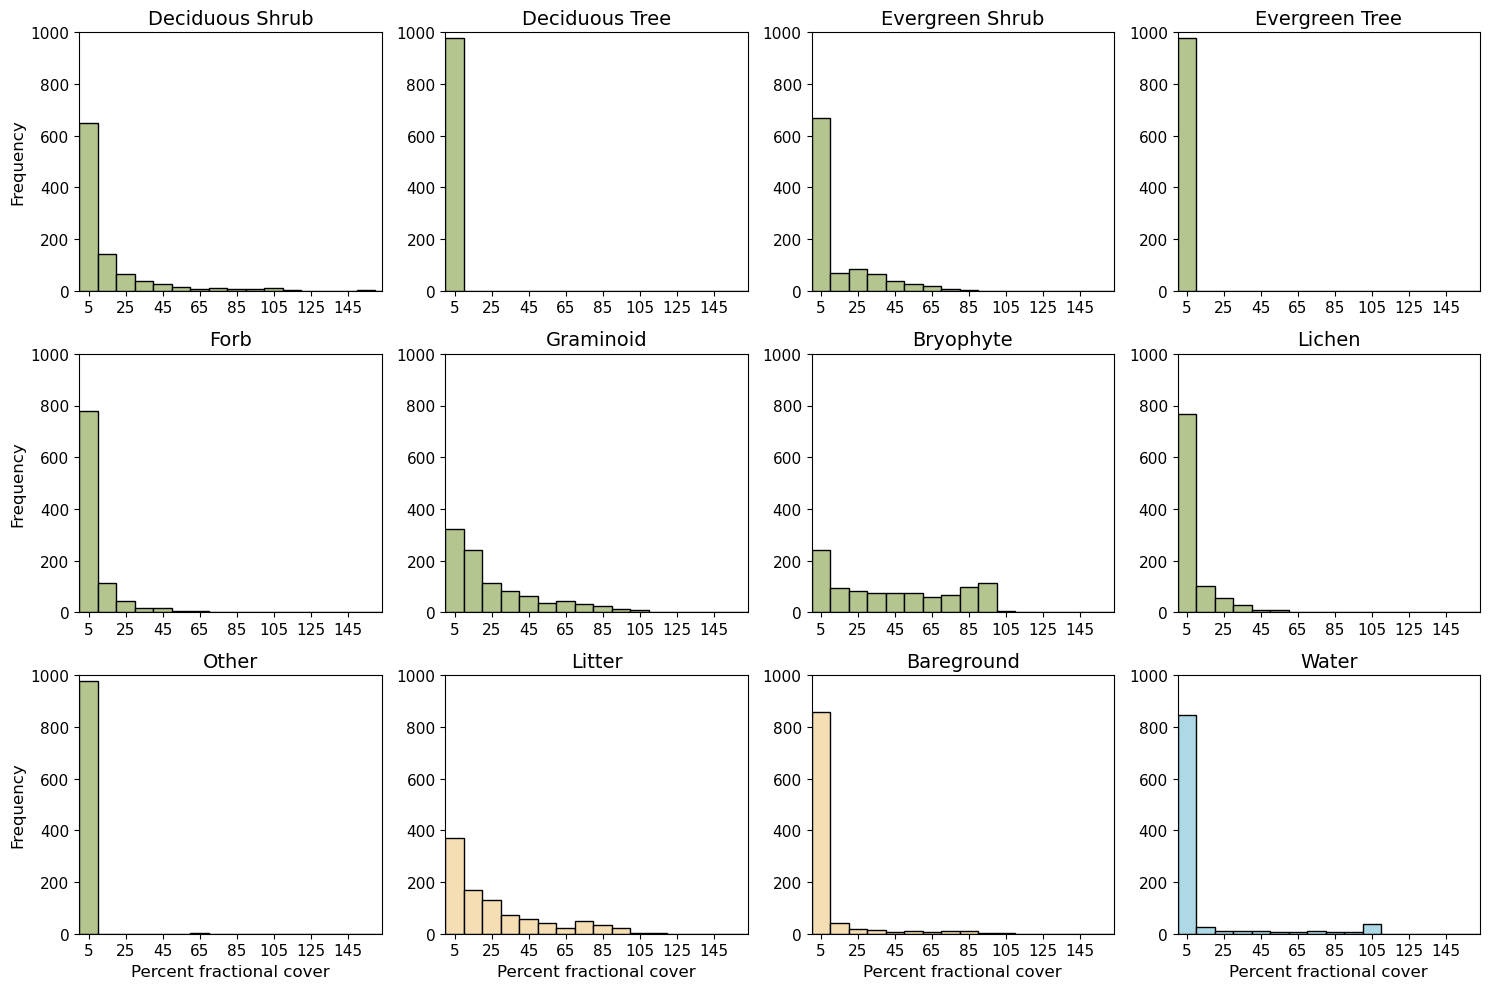

In [16]:
# List of fcover types (assuming columns represent different fcover types)
fcover_types = ['deciduous_shrub_cover', 'deciduous_tree_cover', 'evergreen_shrub_cover', 'evergreen_tree_cover',
                'forb_cover', 'graminoid_cover', 'bryophyte_cover', 'lichen_cover',
                'other_cover', 'litter_cover', 'bareground_cover', 'water_cover']

# Number of subplots (assuming 10 fcover types)
num_subplots = len(fcover_types)
nrows = 3
ncols = ceil(num_subplots / nrows)

# Determine the common x and y axis ranges
all_values = pd.concat([pft_fcover_scaled[col].dropna() for col in fcover_types])
x_min, x_max = all_values.min(), all_values.max()

# Create a figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), sharex=True)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Set Seaborn style and color palette
palette = sns.color_palette("pastel")

# Define bin edges
bin_width = 10  # Adjust as needed
# num_bins = int((x_max - x_min) / bin_width)

# Define bin edges
bin_edges = range(int(x_min), int(x_max) + bin_width, bin_width)

# Set y-axis limits for each plot
y_axis_limits = {
    'Deciduous Shrub': (1000, '#b5c58f'),  # Light olive green
    'Deciduous Tree': (1000, '#b5c58f'),
    'Evergreen Shrub': (1000, '#b5c58f'),
    'Evergreen Tree': (1000, '#b5c58f'),
    'Forb': (1000, '#b5c58f'),
    'Graminoid': (1000, '#b5c58f'),
    'Bryophyte': (1000, '#b5c58f'),
    'Lichen': (1000, '#b5c58f'),
    'Litter': (1000, 'wheat'),  # Assuming 'Litter' as vegetation-related
    'Other': (1000, '#b5c58f'),  # Assuming 'Other' as vegetation-related
    'Water': (1000, 'lightblue'),
    'Bareground': (1000, 'wheat')
}

# Function to format fcover_type titles
def format_fcover_title(fcover_type):
    # Remove '_cover' suffix and capitalize words
    formatted_title = fcover_type.replace('_cover', '').replace('_', ' ').title()
    return formatted_title

# Plot each fcover type in a separate subplot
for i, fcover_type in enumerate(fcover_types):
    title = format_fcover_title(fcover_type)
    y_limit, color = y_axis_limits.get(title, (40, 'lightgray'))  # Default limit and color if not specified
    
    # Generate the histogram data
    n, bins, patches = axs[i].hist(
        pft_fcover[fcover_type], 
        bins=bin_edges, 
        color=color, 
        edgecolor='black', 
        align='mid'
    )

    # Calculate bin centers
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Set the ticks to the bin centers
    tick_spacing = 2  # Adjust as needed
    axs[i].set_xticks(bin_centers[::tick_spacing])
    axs[i].set_xticklabels([f"{int(center)}" for center in bin_centers[::tick_spacing]])
    axs[i].set_title(title, fontsize=14)
    axs[i].set_xlim(x_min, x_max)
    axs[i].set_ylim(0, y_limit)
    axs[i].tick_params(axis='both', which='major', labelsize=11)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    
    # Set x-axis label only for the bottom row
    if i >= (nrows - 1) * ncols:
        axs[i].set_xlabel('Percent fractional cover', fontsize=12)
    
    # Set y-axis label only for the far-left column
    if i % ncols == 0:
        axs[i].set_ylabel('Frequency', fontsize=12)
    
# # Set y-axis limits based on the highest bin count across all subplots
# max_y = max(ax.get_ylim()[1] for ax in axs[:num_subplots])
# for ax in axs[:num_subplots]:
#     ax.set_ylim(0, max_y)

# Remove any empty subplots
for j in range(num_subplots, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
plots_w_other = len(pft_fcover_scaled[pft_fcover_scaled['other_cover'] != 0]) / len(pft_fcover_scaled)
print('Percent of plots containing "other" cover:', round(plots_w_other * 100, 2))

Percent of plots containing "other" cover: 16.97


In [18]:
non_zero_non_null_count = (pft_fcover_scaled.notnull() & (pft_fcover_scaled != 0)).sum().sum()
other_vals_per_total = len(pft_fcover_scaled[pft_fcover_scaled['other_cover'] != 0]) / non_zero_non_null_count
print('Percent of data that is "other" cover:', round(other_vals_per_total*100, 2))

Percent of data that is "other" cover: 2.6


In [19]:
pft_fcover_scaled[pft_fcover_scaled['other_cover'] != 0]['other_cover'].median()

0.5

In [20]:
bioclimate_gdf = gpd.read_file("etc/bioclim/bioclimate_la_latlon.shp")
bioclimate_gdf

,zone,Shape_Leng,Shape_Area,geometry
0,0,2.046336e+07,1.697165e+12,"POLYGON ((-43.38132 60.11147, -43.37944 60.103..."
1,1,2.252616e+07,1.946250e+11,"MULTIPOLYGON (((107.75593 77.30695, 107.75288 ..."
2,2,4.693177e+07,5.116929e+11,"MULTIPOLYGON (((113.31934 75.63689, 113.31125 ..."
3,3,7.821926e+07,1.301256e+12,"MULTIPOLYGON (((171.18156 70.06726, 171.27397 ..."
4,4,8.420476e+07,1.576037e+12,"MULTIPOLYGON (((-172.24023 60.29866, -172.2485..."
5,5,6.435929e+07,1.841596e+12,"MULTIPOLYGON (((137.26956 71.57438, 137.28616 ..."
6,6,2.178417e+06,1.128100e+10,"MULTIPOLYGON (((-163.18776 65.00010, -163.1612..."


---
# 4. Create species to PFT checklist

In [87]:
# create species name dataframe
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
species_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_nonstandard_species_fcover.csv' 
    df = pd.read_csv(path, index_col=0)
    species_dfs.append(df)
species_fcover = pd.concat(species_dfs, axis=0)
species_fcover = species_fcover.reset_index()
species_fcover = species_fcover.rename(columns={'plotName':'unit_id',
                                                'datasetSpeciesName':'dataset_species_name',
                                                'standardHabit':'pft',
                                                'nonstandardHabit':'nonstandard_pft',
                                                'percentCover':'fcover'})
print(len(species_fcover['dataset_species_name'].unique()))
species_fcover.head(3)

2328


,unit_id,dataset_species_name,pft,nonstandard_pft,fcover
0,120712b1,Litter,litter,litter,18.54
1,120713a1,Litter,litter,litter,77.78
2,120713b1,Litter,litter,litter,32.67


## 4a. Replace dataset_species_names adjudicated by an expert

In [88]:
# create replacement dictionary using adjudicated file
adj = pd.read_csv('etc/akveg_species_nomatches_adjudication.csv')
adj_dict = adj.set_index('dataset_species_name')['Timm_adjudicated'].to_dict()
species_fcover['dataset_species_name'] = species_fcover['dataset_species_name'].replace(adj_dict)

## 4b. Create list of possible_accepted_names per unique dataset_species_name

In [89]:
# load akveg checklist and wanted columns
checklist = pd.read_csv('etc/akveg_species_checklist.csv')
checklist = checklist[['Name', 'Accepted Name']]

# Extract the first two words for merging
species_fcover['species_key'] = species_fcover['dataset_species_name'].apply(lambda x: ' '.join(x.split()[:2]))
checklist['name_key'] = checklist['Name'].apply(lambda x: ' '.join(x.split()[:2]))

# Perform the left join
merged_df = pd.merge(
    species_fcover,
    checklist,
    left_on='species_key',
    right_on='name_key',
    how='left'
)

# Drop the temporary columns if desired
merged_df.drop(columns=['species_key', 'name_key'], inplace=True)
grouped_df = merged_df.groupby('dataset_species_name').agg({'Accepted Name': lambda x: set(x)}).reset_index()
grouped_df.rename(columns={'Accepted Name':'possible_accepted_names'}, inplace=True)

# Add missing columns
grouped_df['accepted_species_name'] = np.nan
grouped_df['naming_authority'] = np.nan
grouped_df.head(3)

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{Abietinella abietina (Hedw.) Fleisch.},NaN,NaN
1,Acarospora schleicheri,{Acarospora schleicheri (Ach.) A. Massal.},NaN,NaN
2,Achillea lanulosa,{Achillea millefolium ssp. borealis (Bong.) Br...,NaN,NaN


In [90]:
# File path
file_path = 'etc/species_standardization_mapping.csv'

# Check if the file exists
if os.path.exists(file_path):
    # Read the file
    temp = pd.read_csv(file_path, index_col=0)
    
    # Perform the join and update grouped_df as needed
    merged_df = pd.merge(left=grouped_df, right=temp, 
                         left_on='dataset_species_name', right_on='dataset_species_name', 
                         how='left', suffixes=('', '_temp'))
    merged_df['accepted_species_name'].fillna(merged_df['accepted_species_name_temp'], inplace=True)
    merged_df['naming_authority'].fillna(merged_df['naming_authority_temp'], inplace=True)

    # Drop only the temporary columns that exist
    temp_columns_to_drop = [col for col in merged_df.columns if col.endswith('_temp')]
    merged_df.drop(columns=temp_columns_to_drop, inplace=True)
    
    print("File exists and merge completed.")
else:
    print(f"File '{file_path}' does not exist. Skipping join operation.")
merged_df = merged_df.drop_duplicates(subset=['dataset_species_name'])
merged_df 

File exists and merge completed.


,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{Abietinella abietina (Hedw.) Fleisch.},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
1,Acarospora schleicheri,{Acarospora schleicheri (Ach.) A. Massal.},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
2,Achillea lanulosa,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea L.,Panarctic Flora Project Checklist
3,Achillea millefolium,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea millefolium L.,Flora of North America
4,Achillea millefolium s. borealis,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist
...,...,...,...,...
2285,soil,{nan},NaN,NaN
2286,standingDeadHerbaceous,{nan},NaN,NaN
2287,standingDeadWoody,{nan},NaN,NaN
2288,unknown,{nan},NaN,NaN


In [91]:
# Add naming_authority if missing some
checklist = pd.read_csv('etc/akveg_species_checklist.csv')
merged_df2 = pd.merge(left=merged_df, right=checklist[['Accepted Name', 'Name Source']],
                      left_on='accepted_species_name', right_on='Accepted Name',
                      how='left', suffixes=['', '_checklist'])

# Fill NaN values in merged_df['naming_authority'] with non-NaN values from checklist
merged_df2['naming_authority'].fillna(merged_df2['Name Source'], inplace=True)

# Drop the temporary column from the merge
merged_df2.drop(columns=['Accepted Name', 'Name Source'], inplace=True)
merged_df2.drop_duplicates(subset=['dataset_species_name'], inplace=True)
merged_df2

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{Abietinella abietina (Hedw.) Fleisch.},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
3,Acarospora schleicheri,{Acarospora schleicheri (Ach.) A. Massal.},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
20,Achillea lanulosa,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea L.,Panarctic Flora Project Checklist
21,Achillea millefolium,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea millefolium L.,Flora of North America
59,Achillea millefolium s. borealis,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist
...,...,...,...,...
8691,soil,{nan},NaN,NaN
8692,standingDeadHerbaceous,{nan},NaN,NaN
8693,standingDeadWoody,{nan},NaN,NaN
8694,unknown,{nan},NaN,NaN


In [92]:
# Export
merged_df2.to_csv('etc/species_standardization_mapping_temp.csv', index=None, encoding='utf-8-sig')
merged_df2.head(3)

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{Abietinella abietina (Hedw.) Fleisch.},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
3,Acarospora schleicheri,{Acarospora schleicheri (Ach.) A. Massal.},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
20,Achillea lanulosa,{Achillea millefolium ssp. borealis (Bong.) Br...,Achillea L.,Panarctic Flora Project Checklist


## 4c. Manually assign accepted_species in `etc/species_standardization_mapping_temp` and save as `species_standardization_mapping`

Should have the columns:
- dataset_species_name
- possible_accepted_names
- accepted_name
- naming_authority

## 4d. Load dataframe with manually assigned accepted_name and naming_authority
- If there were no possible_accepted_names, the user should manually assign the naming_authority they referenced when assigning an accepted_name
- If user chose from list of possible_accepted_names as the accepted_name, the naming_authority will be joined to the table later

In [93]:
# load species name dataframe with corresponding accepted names
standard_species = pd.read_csv('etc/species_standardization_mapping.csv')
standard_species

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{'Abietinella abietina (Hedw.) Fleisch.'},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
1,Acarospora schleicheri,{'Acarospora schleicheri (Ach.) A. Massal.'},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
2,Achillea lanulosa,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea L.,Panarctic Flora Project Checklist
3,Achillea millefolium,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea millefolium L.,Flora of North America
4,Achillea millefolium s. borealis,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist
...,...,...,...,...
2285,soil,{nan},NaN,NaN
2286,standingDeadHerbaceous,{nan},NaN,NaN
2287,standingDeadWoody,{nan},NaN,NaN
2288,unknown,{nan},NaN,NaN


## 4e. Check to see if more species need to be added to `species_standardization_mapping.csv`

In [94]:
missing_species = grouped_df[~grouped_df['dataset_species_name'].isin(standard_species['dataset_species_name'])]
if len(missing_species) > 0:
    # export dataframe for editing
    print(f'There are {len(missing_species)} dataset_species_names that need to be assigned an accepted_name.')
    missing_species.to_csv('etc/species_standardization_mapping_temp_01.csv', encoding='utf-8-sig')
else:
    # export empty dataframe
    print('There are no missing species in species_standardization_mapping.')
    missing_species.to_csv('etc/species_standardization_mapping_temp_01.csv', encoding='utf-8-sig')

There are no missing species in species_standardization_mapping.


## 4e(2). Manually assign accepted_names in `etc/species_standardization_mapping_temp_01.csv` and save as `etc/species_standardization_mapping_temp_02.csv`
Once accepted names have been assigned, add the missing species to species_standardization_mapping:

In [95]:
standard_species

,dataset_species_name,possible_accepted_names,accepted_species_name,naming_authority
0,Abietinella abietina,{'Abietinella abietina (Hedw.) Fleisch.'},Abietinella abietina (Hedw.) Fleisch.,Flora of North America
1,Acarospora schleicheri,{'Acarospora schleicheri (Ach.) A. Massal.'},Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria
2,Achillea lanulosa,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea L.,Panarctic Flora Project Checklist
3,Achillea millefolium,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea millefolium L.,Flora of North America
4,Achillea millefolium s. borealis,"{'Achillea millefolium L.', 'Achillea millefol...",Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist
...,...,...,...,...
2285,soil,{nan},NaN,NaN
2286,standingDeadHerbaceous,{nan},NaN,NaN
2287,standingDeadWoody,{nan},NaN,NaN
2288,unknown,{nan},NaN,NaN


In [96]:
# add dataset_species_names to species_standardization_mapping if necessary
added_species = pd.read_csv('etc/species_standardization_mapping_temp_02.csv', index_col=0)
if len(added_species) < 0:
    added_species.rename(columns={'possible_accepted_names':'accepted_species_name'}, inplace=True)
    standard_species = pd.concat([standard_species, added_species])

# overwrite existing mapping file and ensure encoding
standard_species.to_csv('etc/species_standardization_mapping.csv', index=None, encoding='utf-8-sig')

## 4f. Join PFT and other columns to dataset_species_name

In [97]:
# Merge as before
standard_species_fcover = pd.merge(
    left=species_fcover,
    right=standard_species,
    left_on='dataset_species_name',
    right_on='dataset_species_name',
    how='left'
)

# Group by 'dataset_species_name' and aggregate 'unit_id' into a list
species_pft_checklist = standard_species_fcover.groupby('dataset_species_name').agg({
    'unit_id': lambda x: list(x.unique()),  # List of unique unit_id values
    'accepted_species_name': 'first',      # Take the first value
    'naming_authority': 'first',           # Take the first value
    'pft': 'first',                        # Take the first value
    'nonstandard_pft': 'first'             # Take the first value
}).reset_index()

# Reorganize columns
species_pft_checklist = species_pft_checklist[['unit_id', 'accepted_species_name', 'dataset_species_name', 'naming_authority', 'pft', 'nonstandard_pft']]
species_pft_checklist = species_pft_checklist.sort_values(['accepted_species_name'])
species_pft_checklist

,unit_id,accepted_species_name,dataset_species_name,naming_authority,pft,nonstandard_pft
0,"[ADST-33, ADST-63, ADST-67, AFS-23, FMTT-52, G...",Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,Flora of North America,bryophyte,moss
1,"[10, 65, 66, 393, 409, 8, 31]",Acarospora schleicheri (Ach.) A. Massal.,Acarospora schleicheri,Consortium of Lichen Herbaria,lichen,lichen
2,[2010-05],Achillea L.,Achillea lanulosa,Panarctic Flora Project Checklist,forb,forb
3,"[120806a1, 120809a1, 120815a1, AFS-25]",Achillea millefolium L.,Achillea millefolium,Flora of North America,forb,forb
4,"[CAN3, POR2, POR1, 3, 4, 5, 6, 7, 8, 9, 11, 20...",Achillea millefolium ssp. borealis (Bong.) Bre...,Achillea millefolium s. borealis,Panarctic Flora Project Checklist,forb,forb
...,...,...,...,...,...,...
2285,"[BARR_002.basePlot.div.32.2.1, BARR_002.basePl...",None,soil,None,bare ground,soil
2286,"[BARR_003.basePlot.div.40.3.1, BARR_003.basePl...",None,standingDeadHerbaceous,None,litter,litter
2287,"[BARR_004.basePlot.div.41.4.1, BARR_004.basePl...",None,standingDeadWoody,None,litter,litter
2288,[CL_RS1-1_Vg_Comp],None,unknown,None,other,other


In [98]:
# standard_species_fcover = pd.merge(left=species_fcover, right=standard_species, 
#                                       left_on='dataset_species_name', right_on='dataset_species_name', 
#                                       how='left')
# species_pft_checklist = standard_species_fcover.drop(columns=['fcover'])
# species_pft_checklist = species_pft_checklist.drop_duplicates('dataset_species_name')
# species_pft_checklist = species_pft_checklist.reset_index(drop=True)
# species_pft_checklist = species_pft_checklist[['unit_id', 'accepted_species_name', 'dataset_species_name', 'naming_authority', 'pft', 'nonstandard_pft']]
# species_pft_checklist = species_pft_checklist.sort_values(['accepted_species_name'])
# species_pft_checklist

## 4g. Add AKVEG Checklist columns

In [99]:
og_checklist = pd.read_csv('etc/akveg_species_checklist.csv')

# Perform the merge
merged_df = pd.merge(left=species_pft_checklist, 
                     right=og_checklist[['Accepted Name', 'Category', 'Habit', 'Level']],
                     left_on='accepted_species_name', 
                     right_on='Accepted Name', 
                     how='outer')

# Group by accepted_species_name and keep the additional columns
aggregated_df = merged_df.groupby(['dataset_species_name']).agg({
    'unit_id': 'first',
    'Category': lambda x: set(x.dropna()),  # Remove NaN values and aggregate to sets
    'Habit': lambda x: set(x.dropna()),
    'Level': 'first',
    'accepted_species_name': 'first',        # Keep the first occurrence
    'naming_authority': 'first',             # Keep the first occurrence
    'pft': 'first',                          # Keep the first occurrence
    'nonstandard_pft': 'first',
}).reset_index()

# View the final dataframe
aggregated_df = aggregated_df.rename(columns={'Category':'category', 
                                              'Habit':'habit',
                                              'Level':'taxon_rank'})
aggregated_df

,dataset_species_name,unit_id,category,habit,taxon_rank,accepted_species_name,naming_authority,pft,nonstandard_pft
0,Abietinella abietina,"[ADST-33, ADST-63, ADST-67, AFS-23, FMTT-52, G...",{moss},{moss},species,Abietinella abietina (Hedw.) Fleisch.,Flora of North America,bryophyte,moss
1,Acarospora schleicheri,"[10, 65, 66, 393, 409, 8, 31]",{lichen},{lichen},species,Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria,lichen,lichen
2,Achillea lanulosa,[2010-05],{eudicot},{forb},genus,Achillea L.,Panarctic Flora Project Checklist,forb,forb
3,Achillea millefolium,"[120806a1, 120809a1, 120815a1, AFS-25]",{eudicot},{forb},species,Achillea millefolium L.,Flora of North America,forb,forb
4,Achillea millefolium s. borealis,"[CAN3, POR2, POR1, 3, 4, 5, 6, 7, 8, 9, 11, 20...",{eudicot},{forb},subspecies,Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist,forb,forb
...,...,...,...,...,...,...,...,...,...
2285,soil,"[BARR_002.basePlot.div.32.2.1, BARR_002.basePl...",{},{},None,None,None,bare ground,soil
2286,standingDeadHerbaceous,"[BARR_003.basePlot.div.40.3.1, BARR_003.basePl...",{},{},None,None,None,litter,litter
2287,standingDeadWoody,"[BARR_004.basePlot.div.41.4.1, BARR_004.basePl...",{},{},None,None,None,litter,litter
2288,unknown,[CL_RS1-1_Vg_Comp],{},{},None,None,None,other,other


In [100]:
# Function to convert sets to comma-separated strings and handle empty sets
def format_set_to_string(s):
    if isinstance(s, set):
        if len(s) == 0:  # Check if the set is empty
            return ''
        else:
            return ', '.join(s)  # Convert set to comma-separated string
    return s  # If not a set, return the value as is

# Apply the function to the 'Category' and 'Habit' columns
aggregated_df['category'] = aggregated_df['category'].apply(format_set_to_string)
aggregated_df['habit'] = aggregated_df['habit'].apply(format_set_to_string)

# View the updated dataframe
aggregated_df

,dataset_species_name,unit_id,category,habit,taxon_rank,accepted_species_name,naming_authority,pft,nonstandard_pft
0,Abietinella abietina,"[ADST-33, ADST-63, ADST-67, AFS-23, FMTT-52, G...",moss,moss,species,Abietinella abietina (Hedw.) Fleisch.,Flora of North America,bryophyte,moss
1,Acarospora schleicheri,"[10, 65, 66, 393, 409, 8, 31]",lichen,lichen,species,Acarospora schleicheri (Ach.) A. Massal.,Consortium of Lichen Herbaria,lichen,lichen
2,Achillea lanulosa,[2010-05],eudicot,forb,genus,Achillea L.,Panarctic Flora Project Checklist,forb,forb
3,Achillea millefolium,"[120806a1, 120809a1, 120815a1, AFS-25]",eudicot,forb,species,Achillea millefolium L.,Flora of North America,forb,forb
4,Achillea millefolium s. borealis,"[CAN3, POR2, POR1, 3, 4, 5, 6, 7, 8, 9, 11, 20...",eudicot,forb,subspecies,Achillea millefolium ssp. borealis (Bong.) Bre...,Panarctic Flora Project Checklist,forb,forb
...,...,...,...,...,...,...,...,...,...
2285,soil,"[BARR_002.basePlot.div.32.2.1, BARR_002.basePl...",,,None,None,None,bare ground,soil
2286,standingDeadHerbaceous,"[BARR_003.basePlot.div.40.3.1, BARR_003.basePl...",,,None,None,None,litter,litter
2287,standingDeadWoody,"[BARR_004.basePlot.div.41.4.1, BARR_004.basePl...",,,None,None,None,litter,litter
2288,unknown,[CL_RS1-1_Vg_Comp],,,None,None,None,other,other


In [101]:
# export
aggregated_df = aggregated_df.replace({None: np.nan, '':np.nan, -999: np.nan, '-999':np.nan})
aggregated_df = aggregated_df[['unit_id',
                               'accepted_species_name',
                               'dataset_species_name',
                               'taxon_rank',
                               'naming_authority',
                               'category',
                               'habit',
                               'pft',
                               'nonstandard_pft']]
aggregated_df

,unit_id,accepted_species_name,dataset_species_name,taxon_rank,naming_authority,category,habit,pft,nonstandard_pft
0,"[ADST-33, ADST-63, ADST-67, AFS-23, FMTT-52, G...",Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss
1,"[10, 65, 66, 393, 409, 8, 31]",Acarospora schleicheri (Ach.) A. Massal.,Acarospora schleicheri,species,Consortium of Lichen Herbaria,lichen,lichen,lichen,lichen
2,[2010-05],Achillea L.,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb
3,"[120806a1, 120809a1, 120815a1, AFS-25]",Achillea millefolium L.,Achillea millefolium,species,Flora of North America,eudicot,forb,forb,forb
4,"[CAN3, POR2, POR1, 3, 4, 5, 6, 7, 8, 9, 11, 20...",Achillea millefolium ssp. borealis (Bong.) Bre...,Achillea millefolium s. borealis,subspecies,Panarctic Flora Project Checklist,eudicot,forb,forb,forb
...,...,...,...,...,...,...,...,...,...
2285,"[BARR_002.basePlot.div.32.2.1, BARR_002.basePl...",NaN,soil,NaN,NaN,NaN,NaN,bare ground,soil
2286,"[BARR_003.basePlot.div.40.3.1, BARR_003.basePl...",NaN,standingDeadHerbaceous,NaN,NaN,NaN,NaN,litter,litter
2287,"[BARR_004.basePlot.div.41.4.1, BARR_004.basePl...",NaN,standingDeadWoody,NaN,NaN,NaN,NaN,litter,litter
2288,[CL_RS1-1_Vg_Comp],NaN,unknown,NaN,NaN,NaN,NaN,other,other


### 4h. Make final manual adjustments to the checklist in `etc/species_pft_checklist_temp.csv` and export as `species_pft_checklist.csv` in the main directory

In [102]:
# export to make any final manual adjustments
aggregated_df.to_csv('etc/species_pft_checklist_temp.csv', index=False, encoding='utf-8-sig')

In [112]:
# ensure encoding is correct
pft_checklist = pd.read_csv('species_pft_checklist.csv')
pft_checklist.to_csv('species_pft_checklist.csv', index=False, encoding='utf-8-sig')
pft_checklist = pd.read_csv('species_pft_checklist.csv')
pft_checklist

,unit_id,accepted_species_name,dataset_species_name,taxon_rank,naming_authority,category,habit,pft,nonstandard_pft
0,"['ADST-33', 'ADST-63', 'ADST-67', 'AFS-23', 'F...",Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss
1,"['10', '65', '66', '393', '409', '8', '31']",Acarospora schleicheri (Ach.) A. Massal.,Acarospora schleicheri,species,Consortium of Lichen Herbaria,lichen,lichen,lichen,lichen
2,['2010-05'],Achillea L.,Achillea lanulosa,genus,Panarctic Flora Project Checklist,eudicot,forb,forb,forb
3,"['120806a1', '120809a1', '120815a1', 'AFS-25']",Achillea millefolium L.,Achillea millefolium,species,Flora of North America,eudicot,forb,forb,forb
4,"['CAN3', 'POR2', 'POR1', '3', '4', '5', '6', '...",Achillea millefolium ssp. borealis (Bong.) Bre...,Achillea millefolium s. borealis,subspecies,Panarctic Flora Project Checklist,eudicot,forb,forb,forb
...,...,...,...,...,...,...,...,...,...
2285,"['GAAR_T96_01_2008', 'GAAR_T96_06_2008', 'KOVA...",Woodsia glabella R. Br. ex Richardson,Woodsia glabella,species,Panarctic Flora Project Checklist,fern,spore-bearing,forb,spore-bearing
2286,"['GAAR_T90_13_2008', 'GAAR_T90_14_2008', 'GAAR...",Woodsia ilvensis (L.) R. Br.,Woodsia ilvensis,species,Panarctic Flora Project Checklist,fern,spore-bearing,forb,spore-bearing
2287,['LAVA-C'],Woodsia R. Br.,Woodsia species,genus,Panarctic Flora Project Checklist,fern,spore-bearing,forb,spore-bearing
2288,"['BELA_T03_01_2002', 'BELA_T03_02_2002', 'BELA...",Xanthoria (Fr.) Th. Fr.,Xanthoria,genus,Consortium of Lichen Herbaria,NaN,NaN,lichen,lichen


### Unique accepted species in the full checklist

In [113]:
len(pft_checklist['accepted_species_name'].dropna().unique())

1711

### Unique accepted species per data source (species/subspecies only)

In [114]:
pft_checklist['unit_id'] = pft_checklist['unit_id'].apply(ast.literal_eval)
pft_exploded = pft_checklist.explode("unit_id", ignore_index=True)
pft_exploded

,unit_id,accepted_species_name,dataset_species_name,taxon_rank,naming_authority,category,habit,pft,nonstandard_pft
0,ADST-33,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss
1,ADST-63,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss
2,ADST-67,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss
3,AFS-23,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss
4,FMTT-52,Abietinella abietina (Hedw.) Fleisch.,Abietinella abietina,species,Flora of North America,moss,moss,bryophyte,moss
...,...,...,...,...,...,...,...,...,...
93678,3,Rusavskia elegans (Link) S.Y. Kondr. & Kärnefelt,Xanthoria elegans,species,Arup et al. 2013,lichen,lichen,lichen,lichen
93679,407,Rusavskia elegans (Link) S.Y. Kondr. & Kärnefelt,Xanthoria elegans,species,Arup et al. 2013,lichen,lichen,lichen,lichen
93680,33,Rusavskia elegans (Link) S.Y. Kondr. & Kärnefelt,Xanthoria elegans,species,Arup et al. 2013,lichen,lichen,lichen,lichen
93681,1411,Rusavskia elegans (Link) S.Y. Kondr. & Kärnefelt,Xanthoria elegans,species,Arup et al. 2013,lichen,lichen,lichen,lichen


In [106]:
# count of species/subspecies only
checklist_w_info = pd.merge(left=pft_exploded, 
                            right=aux[['unit_id', 'data_source', 'data_subsource']],
                            left_on='unit_id', right_on='unit_id', how='right')
checklist_w_info = checklist_w_info[checklist_w_info['taxon_rank'].str.contains('species', na=False)]
checklist_w_info.groupby('data_subsource')['accepted_species_name'].nunique()

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    461
Atqasuk Villarreal (pub 2013)                    111
Barrow DOE NGEE Sloan (pub 2014)                  37
Barrow IBP Tundra Biome Villarreal (pub 2012)     58
Flux Tower Zona Davidson (pub 2016)               62
NGEE-Arctic Amy Breen (pub 2020)                 200
Prudhoe ArcSEES road study Walker (pub 2015)      52
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     43
Shell Onshore Macander (pub 2017)                294
Toolik Field Station NEON (pub 2021)              61
Utqiagvik-Barrow NEON (pub 2021)                  45
Name: accepted_species_name, dtype: int64

### Unique accepted species per data source (subspecies, species, genus, type, family, nan)

In [107]:
# count of ALL species (type, family, genus, species, subspecies)
checklist_w_info = pd.merge(left=pft_exploded, 
                            right=aux[['unit_id', 'data_source', 'data_subsource']],
                            left_on='unit_id', right_on='unit_id', how='right')
checklist_w_info.groupby('data_subsource')['accepted_species_name'].nunique()

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    526
Atqasuk Villarreal (pub 2013)                    134
Barrow DOE NGEE Sloan (pub 2014)                  47
Barrow IBP Tundra Biome Villarreal (pub 2012)     63
Flux Tower Zona Davidson (pub 2016)               74
NGEE-Arctic Amy Breen (pub 2020)                 210
Prudhoe ArcSEES road study Walker (pub 2015)      56
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     45
Shell Onshore Macander (pub 2017)                350
Toolik Field Station NEON (pub 2021)              65
Utqiagvik-Barrow NEON (pub 2021)                  55
Name: accepted_species_name, dtype: int64

### Unique accepted species of the survey data only

In [109]:
checklist_w_info_sp = checklist_w_info[checklist_w_info['taxon_rank'].str.contains('species', na=False)]
checklist_w_info_sp['accepted_species_name'].nunique()

631

### Unique accepted species including all AVA data (pre-2010)

In [110]:
# count of ALL species (type, family, genus, species, subspecies)
all_species = pd.merge(left=pft_exploded, 
                       right=aux[['unit_id', 'data_source', 'data_subsource']],
                       left_on='unit_id', right_on='unit_id', how='left')
checklist_w_info.groupby('data_source')['accepted_species_name'].nunique(dropna=False)

data_source
ABR      351
AKVEG    527
AVA      231
NEON     106
NGA      211
Name: accepted_species_name, dtype: int64

---
# 5. Create species fcover table

In [70]:
standard_species_fcover = standard_species_fcover[['unit_id', 'accepted_species_name', 'pft', 'fcover']]
standard_species_fcover

,unit_id,accepted_species_name,pft,fcover
0,120712b1,NaN,litter,18.54
1,120713a1,NaN,litter,77.78
2,120713b1,NaN,litter,32.67
3,120714a1,NaN,litter,15.23
4,120714a2,NaN,litter,84.87
...,...,...,...,...
95376,TL_WNAC7_VgComp,Drepanocladus polygamus (Schimp.) Hedenäs,bryophyte,1.00
95377,TL_WNAC7_VgComp,Blepharostoma trichophyllum (L.) Dumort.,bryophyte,1.00
95378,TL_WNAC7_VgComp,Campylophyllum sommerfeltii (Myr.) Hedenäs,bryophyte,1.00
95379,TL_WNAC7_VgComp,Scorpidium revolvens (Sw.) Hedenäs,bryophyte,1.00


In [71]:
# Group by 'plotName' and 'acceptedName' and sum the 'percentCover' values
standard_species_fcover = standard_species_fcover.groupby(['unit_id', 'accepted_species_name'], as_index=False)['fcover'].sum()
standard_species_fcover

,unit_id,accepted_species_name,fcover
0,010A,Abietinella abietina (Hedw.) Fleisch.,0.10
1,010A,Alectoria nigricans (Ach.) Nyl.,0.10
2,010A,Alopecurus borealis Trin.,0.10
3,010A,Bistorta vivipara (L.) Delarbre,0.70
4,010A,Bryum Hedw.,0.10
...,...,...,...
91046,YUK9,Populus balsamifera L.,37.50
91047,YUK9,Rosa acicularis Lindl.,15.00
91048,YUK9,Rubus idaeus L.,0.55
91049,YUK9,Tanacetum bipinnatum (L.) Sch. Bip.,0.55


In [72]:
len(standard_species_fcover['accepted_species_name'].unique())

1711

In [73]:
# Get the unique plot IDs from aux
post2010_plot_ids = aux['unit_id'].unique()

# Filter the dataframe to only include rows where plotName is in valid_plot_ids
post2010_standard_species_fcover = standard_species_fcover[standard_species_fcover['unit_id'].isin(post2010_plot_ids)]
post2010_standard_species_fcover.set_index('unit_id', inplace=True)
post2010_standard_species_fcover

,accepted_species_name,fcover
unit_id,,
120712b1,Alnus alnobetula ssp. fruticosa (Rupr.) Raus.,10.60
120712b1,Andromeda polifolia L.,0.66
120712b1,Aulacomnium turgidum (Wahlenb.) Schwägr.,3.97
120712b1,Betula nana L.,5.96
120712b1,Carex bigelowii Torr. ex Schwein.,11.26
...,...,...
TOOL_043.basePlot.div.41.4.1,Eriophorum vaginatum L.,14.00
TOOL_043.basePlot.div.41.4.1,Rhododendron tomentosum Harmaja,16.00
TOOL_043.basePlot.div.41.4.1,Rubus chamaemorus L.,37.00


In [75]:
post2010_standard_species_fcover = post2010_standard_species_fcover.replace({None: np.nan, '':np.nan, -999:np.nan})
post2010_standard_species_fcover.to_csv('synthesized_species_fcover.csv', index=True, encoding='utf-8-sig')

In [76]:
aux.columns

Index(['unit_id', 'survey_year', 'survey_month', 'survey_day', 'plot_radius',
       'latitude_y', 'longitude_x', 'georef_source', 'georef_accuracy',
       'coord_epsg', 'data_subsource', 'data_source', 'data_source_html',
       'data_subsource_citation', 'survey_method', 'fcover_scale',
       'survey_purpose', 'geometry', 'admin_unit', 'admin_country',
       'fire_years', 'bioclim_subzone', 'duplicated_coords',
       'duplicated_date'],
      dtype='object')

In [77]:
temp = pd.merge(left=post2010_standard_species_fcover.reset_index(), right=aux[['unit_id','data_subsource', 'data_source']],
                left_on='unit_id', right_on='unit_id', how='left')
temp.groupby('data_subsource')['accepted_species_name'].nunique()

data_subsource
AIM NPR-A Nawrocki (pub 2020)                    526
Atqasuk Villarreal (pub 2013)                    134
Barrow DOE NGEE Sloan (pub 2014)                  47
Barrow IBP Tundra Biome Villarreal (pub 2012)     63
Flux Tower Zona Davidson (pub 2016)               74
NGEE-Arctic Amy Breen (pub 2020)                 210
Prudhoe ArcSEES road study Walker (pub 2015)      56
Prudhoe Bay Airport ArcSEES Walker (pub 2016)     45
Shell Onshore Macander (pub 2017)                350
Toolik Field Station NEON (pub 2021)              65
Utqiagvik-Barrow NEON (pub 2021)                  55
Name: accepted_species_name, dtype: int64

In [78]:
temp.groupby('data_source')['accepted_species_name'].nunique()

data_source
ABR      350
AKVEG    526
AVA      230
NEON     105
NGA      210
Name: accepted_species_name, dtype: int64

---
# 6. Plot overlap with CAVM zones if not in aux

In [65]:
from osgeo import gdal
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.plot import show

# Load your raster file
raster_path = 'etc/raster_cavm/raster_cavm_v1.tif'
src = rasterio.open(raster_path)

# Load points
gdf = aux_gdf.copy()
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(src.crs)

In [66]:
gdf.head(3)

,unit_id,survey_year,survey_month,survey_day,plot_radius,latitude_y,longitude_x,georef_source,georef_accuracy,coord_epsg,...,fcover_scale,survey_purpose,admin_unit,admin_country,fire_years,duplicated_coords,duplicated_date,cavm_unit,cavm_unit_description,geometry
0,120712b1,2012,7,12.0,55.0,69.362520,-152.13188,GPS,NaN,EPSG:4326,...,percent,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,NaN,NaN,G4,"Tussock-sedge, dwarf-shrub, moss tundra",POINT (1066879.125 -2017698.006)
1,120713a1,2012,7,13.0,55.0,70.515810,-157.26028,GPS,NaN,EPSG:4326,...,percent,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,NaN,"['120713a1', '120713b1']",W2,"Sedge, moss, dwarf-shrub wetland complex",POINT (833437.599 -1988523.445)
2,120713b1,2012,7,13.0,55.0,69.810196,-152.35090,GPS,NaN,EPSG:4326,...,percent,Conduct vegetation assessments and paired remo...,Alaska,United States of America,NaN,NaN,"['120713a1', '120713b1']",G3,"Non-tussock sedge, dwarf-shrub, moss tundra",POINT (1036423.707 -1978364.583)


In [67]:
gdf.total_bounds

array([  675375.16374252, -2703942.74126575,  1207305.06962302,
       -1864701.85086807])

<Axes: >

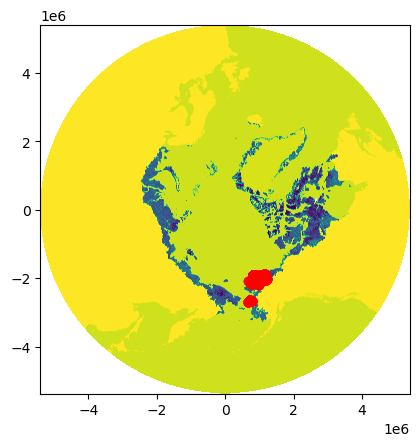

In [68]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent = [gdf.total_bounds[0], gdf.total_bounds[2], gdf.total_bounds[1], gdf.total_bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax)

gdf.plot(ax=ax, color='red')

In [69]:
# sample raster at coordinates
coord_list = [(x, y) for x, y in zip(gdf['geometry'].x, gdf['geometry'].y)]
gdf['raster_value'] = [x[0] for x in src.sample(coord_list)]

In [70]:
if 'cavm_unit' not in gdf.columns.to_list():
    # Load the raster legend CSV
    legend_path = 'etc/raster_cavm/raster_cavm_legend.csv'
    legend_df = pd.read_csv(legend_path)
    
    # Ensure that 'cavm_zone' in aux_gdf and 'Raster code' in legend_df are of the same type
    gdf['raster_value'] = gdf['raster_value'].astype(str)  # Adjust type as necessary
    legend_df['Raster code'] = legend_df['Raster code'].astype(str)  # Adjust type as necessary

    # Perform the left join
    new_aux_table = gdf.merge(legend_df, left_on='raster_value', right_on='Raster code', how='left')
    new_aux_table.drop(columns=['raster_value', 'Raster code', '# Pixels', 'Area  (1000 km2)', 'Long Description', 'geometry'], inplace=True)
    new_aux_table.rename(columns={'Vegetation Unit':'cavm_unit', 'Short Description':'cavm_unit_description'}, inplace=True)
    new_aux_table = new_aux_table.set_index('unit_id')
    new_aux_table.to_csv('survey_unit_information.csv', index=True)
else:
    print('cavm_unit already present in auxiliary table.')

cavm_unit already present in auxiliary table.


In [71]:
# extract
cavm_info = gdf[['unit_id', 'geometry', 'cavm_unit', 'cavm_unit_description']]
pft_cavm = pft_fcover.merge(cavm_info, left_on='unit_id', right_on='unit_id', how='left')

In [72]:
import xml.etree.ElementTree as ET
import re

# Path to your QML file
qml_file = 'cavm_colors.qml'

# Parse the XML
tree = ET.parse(qml_file)
root = tree.getroot()

# Locate the color palette entries
palette_entries = []
for palette_entry in root.findall(".//colorPalette/paletteEntry"):
    value = palette_entry.get('value')
    color = palette_entry.get('color')
    alpha = palette_entry.get('alpha')
    label = palette_entry.get('label')
    
    # Remove the " -- text" part from the label
    cleaned_label = re.sub(r' -.*', '', label)
    
    palette_entries.append({
        'value': value,
        'color': color,
        'alpha': alpha,
        'label': cleaned_label
    })

# Display the cleaned data
for entry in palette_entries:
    print(f"Value: {entry['value']}, Color: {entry['color']}, Alpha: {entry['alpha']}, Label: {entry['label']}")

Value: 1, Color: #d7d7b3, Alpha: 178, Label: B1
Value: 2, Color: #a8a802, Alpha: 178, Label: B2a
Value: 3, Color: #a68282, Alpha: 178, Label: B3
Value: 4, Color: #8282a0, Alpha: 178, Label: B4
Value: 5, Color: #cdcd66, Alpha: 178, Label: B2b
Value: 21, Color: #ffebaf, Alpha: 178, Label: G1
Value: 22, Color: #ffd37f, Alpha: 178, Label: G2
Value: 23, Color: #e6e600, Alpha: 178, Label: G3
Value: 24, Color: #ffff00, Alpha: 178, Label: G4
Value: 31, Color: #dfb0b0, Alpha: 178, Label: P1
Value: 32, Color: #db949e, Alpha: 178, Label: P2
Value: 33, Color: #97e602, Alpha: 178, Label: S1
Value: 34, Color: #38a802, Alpha: 178, Label: S2
Value: 41, Color: #9eedbd, Alpha: 178, Label: W1
Value: 42, Color: #73ffdf, Alpha: 178, Label: W2
Value: 43, Color: #04e6a9, Alpha: 178, Label: W3
Value: 91, Color: #0070ff, Alpha: 178, Label: FW
Value: 92, Color: #e0f2ff, Alpha: 178, Label: SW
Value: 93, Color: #ffffff, Alpha: 178, Label: GL
Value: 99, Color: #cccccc, Alpha: 178, Label: NA


In [73]:
palette_entries

[{'value': '1', 'color': '#d7d7b3', 'alpha': '178', 'label': 'B1'},
 {'value': '2', 'color': '#a8a802', 'alpha': '178', 'label': 'B2a'},
 {'value': '3', 'color': '#a68282', 'alpha': '178', 'label': 'B3'},
 {'value': '4', 'color': '#8282a0', 'alpha': '178', 'label': 'B4'},
 {'value': '5', 'color': '#cdcd66', 'alpha': '178', 'label': 'B2b'},
 {'value': '21', 'color': '#ffebaf', 'alpha': '178', 'label': 'G1'},
 {'value': '22', 'color': '#ffd37f', 'alpha': '178', 'label': 'G2'},
 {'value': '23', 'color': '#e6e600', 'alpha': '178', 'label': 'G3'},
 {'value': '24', 'color': '#ffff00', 'alpha': '178', 'label': 'G4'},
 {'value': '31', 'color': '#dfb0b0', 'alpha': '178', 'label': 'P1'},
 {'value': '32', 'color': '#db949e', 'alpha': '178', 'label': 'P2'},
 {'value': '33', 'color': '#97e602', 'alpha': '178', 'label': 'S1'},
 {'value': '34', 'color': '#38a802', 'alpha': '178', 'label': 'S2'},
 {'value': '41', 'color': '#9eedbd', 'alpha': '178', 'label': 'W1'},
 {'value': '42', 'color': '#73ffdf', 

/tmp/ipykernel_147986/1415996840.py:208: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


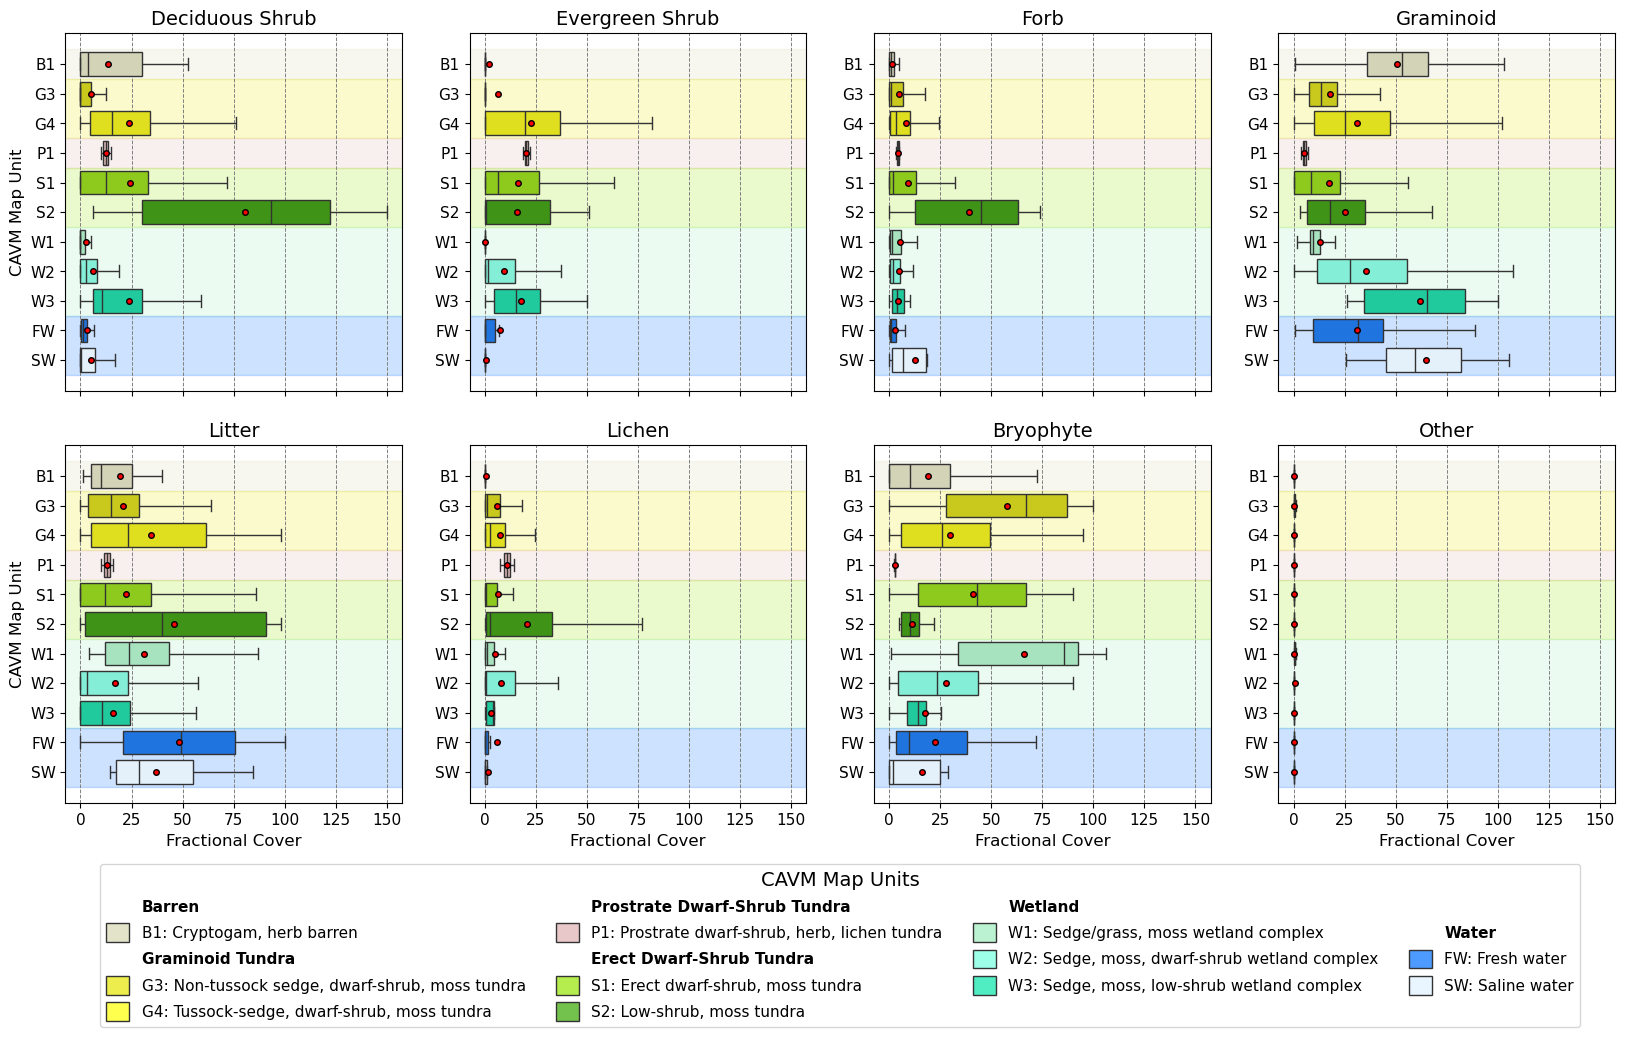

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import pandas as pd

# Define the cover types to plot
cover_types = [
    'deciduous_shrub_cover',
    'evergreen_shrub_cover',
    'forb_cover',
    'graminoid_cover',
    'litter_cover',
    'lichen_cover',
    'bryophyte_cover',
    'other_cover'
]

# Melt the DataFrame to long format
melted_pft = pft_cavm.melt(id_vars=['cavm_unit', 'cavm_unit_description'], 
                            value_vars=cover_types,
                            var_name='Cover Type', 
                            value_name='Fractional Cover')

# Get unique vegetation units and their descriptions
veg_unit_info = pft_cavm[['cavm_unit', 'cavm_unit_description']].drop_duplicates()

# Create the color map from palette_entries
color_map = {}
for entry in palette_entries:
    color = entry['color']
    alpha = int(entry['alpha']) / 255  # Convert alpha from 0-255 to 0-1
    rgba_color = mcolors.hex2color(color) + (alpha,)  # Convert hex to RGBA
    color_map[entry['label']] = rgba_color

# Define custom sorting for y-axis based on the categories (B, G, P, S, W)
category_order = ['B', 'G', 'P', 'S', 'W']

# Create a custom map for cavm_unit values to categories
unit_category_map = {
    'B1': 'B', 'B2a': 'B', 'B3': 'B', 'B4': 'B', 'B2b': 'B',
    'G1': 'G', 'G2': 'G', 'G3': 'G', 'G4': 'G',
    'P1': 'P', 'P2': 'P',
    'S1': 'S', 'S2': 'S',
    'W1': 'W', 'W2': 'W', 'W3': 'W',
    'FW': 'W', 'SW': 'W', 'GL': 'W', 'NA': 'W'
}

# Add a new column for category in melted_pft
melted_pft['Category'] = melted_pft['cavm_unit'].map(unit_category_map)

# Convert 'cavm_unit' to categorical type to ensure ordering
melted_pft['cavm_unit'] = pd.Categorical(melted_pft['cavm_unit'],
                                           categories=[unit for unit in unit_category_map if unit_category_map[unit] in category_order],
                                           ordered=True)

# Set up the number of columns for the subplot grid
num_cols = 4  # Adjusting for 2 rows of 4 columns
num_units = len(cover_types)
num_rows = int(np.ceil(num_units / num_cols))

# Set up the subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

fill_regions = [('B1','B1'),
                ('G3','G4'),
                ('P1','P1'),
                ('S1','S2'),
                ('W1','W3'),
                ('FW','SW')]

# Apply fill based on regions
for i, (ax, cover_type) in enumerate(zip(axes, cover_types)):
    title = cover_type.replace('_', ' ').replace(' cover', '').title()
    
    current_data = melted_pft[melted_pft['Cover Type'] == cover_type].copy()
    units_with_data = current_data['cavm_unit'].unique()
    filtered_unit_category_map = {unit: category for unit, category in unit_category_map.items() if unit in units_with_data}
    
    current_data.loc[:, 'cavm_unit'] = pd.Categorical(current_data['cavm_unit'],
                                                       categories=[unit for unit in filtered_unit_category_map if filtered_unit_category_map[unit] in category_order][::-1],
                                                       ordered=True)
    
    sns.boxplot(
        data=current_data,
        x='Fractional Cover',
        y='cavm_unit',
        hue='cavm_unit',
        ax=ax,
        palette=color_map,
        dodge=False,
        showfliers=False,
        showmeans=True, 
        meanprops={'marker':'o',
                   'markerfacecolor':'red',
                   'markeredgecolor':'black',
                   'markersize':'4'}
    )

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Fractional Cover', fontsize=12)
    
    if i % num_cols == 0:
        ax.set_ylabel('CAVM Map Unit', fontsize=12)
    else:
        ax.set_ylabel('')
    
    ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='grey')

    # Loop through each defined region to apply non-overlapping shading
    for start_unit, end_unit in fill_regions:
        start_pos = current_data['cavm_unit'].cat.categories.get_loc(start_unit) + 0.5
        end_pos = current_data['cavm_unit'].cat.categories.get_loc(end_unit) - 0.5

        color = color_map[start_unit]
        
        # Apply the shading without overlap
        ax.axhspan(
            ymin=end_pos, ymax=start_pos,  # Corrected start and end
            color=color,
            alpha=0.2  # Set alpha for subtle shading
        )
    ax.tick_params(axis='both', which='major', labelsize=11)
    ax.invert_yaxis()

# Adjust space around the subplots
plt.subplots_adjust(hspace=0.15)  # Decrease hspace to bring rows closer together

# Create a custom legend with sorted handles and dark grey borders
# Sort the handles based on the y-axis order
ordered_units = melted_pft['cavm_unit'].cat.categories
units_in_graph = current_data['cavm_unit'].unique()

# Create the legend handles with adjusted column distribution
sections = {
    'Barren': ['B1'],
    'Graminoid Tundra': ['G3', 'G4'],
    'Prostrate Dwarf-Shrub Tundra': ['P1'],
    'Erect Dwarf-Shrub Tundra': ['S1', 'S2'],
    'Wetland': ['W1', 'W2', 'W3'],
    'Water': ['FW', 'SW']
}

# Create legend handles and their corresponding labels
handles = []
for section, units in sections.items():
    # Create a dummy patch for the section title with bold label
    section_title_patch = mpatches.Patch(
        facecolor='none',  # Make section title "empty"
        edgecolor='none',  # No border for the title
        label=f'{section}',  # Set the section title as the label
    )
    handles.append(section_title_patch)  # Add the section title to the handles list
    
    # Add the unit legend handles below the section title
    for unit in units:
        # Check if the unit exists in veg_unit_info
        unit_description = veg_unit_info[veg_unit_info['cavm_unit'] == unit]['cavm_unit_description']
        
        if not unit_description.empty:
            description = unit_description.values[0]
        else:
            description = "Description not available"  # Fallback description
        
        # Create the patch (legend item) for this unit
        handles.append(
            mpatches.Patch(
                facecolor=color_map[unit],  # Use facecolor instead of color
                label=f"{unit}: {description}",
                edgecolor='#333333',  # Dark grey border around the color box
                linewidth=1  # Set border width
            )
        )

    # Add dummy patches to align legend items in columns
    if section == 'Wetland':  # Needs 1 dummy item
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))
    elif section == 'Other':
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))
        handles.append(mpatches.Patch(facecolor='none', edgecolor='none', label=' '))

# Create the legend with sections and unit handles
plt.legend(
    handles=handles,
    title='CAVM Map Units',
    bbox_to_anchor=(-1.3, -0.15),
    loc='upper center',
    ncol=4,
    fontsize=11,  # Font size for legend items
    title_fontsize=14,  # Font size for the legend title
    handlelength=1.5,  # Adjust handle length for better spacing
    handleheight=1.5,  # Adjust handle height
)

# Customize the section titles to be bold
for label in plt.gca().get_legend().get_texts():
    if label.get_text() in sections:  # Check if the label is a section title
        label.set_fontweight('bold')  # Set the section title to bold

# Hide any unused axes
for i in range(len(cover_types), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()